## Import Imporatnt Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

## Load The DataSet

In [2]:
# Load the dataset
xls = pd.ExcelFile("/content/E-commerce_data.xlsx")

# Load relevant sheets
customers = pd.read_excel(xls, sheet_name="customers")
genders = pd.read_excel(xls, sheet_name="genders")
cities = pd.read_excel(xls, sheet_name="cities")
transactions = pd.read_excel(xls, sheet_name="transactions")
branches = pd.read_excel(xls, sheet_name="branches")
merchants = pd.read_excel(xls, sheet_name="merchants")

# Display Data
print("Customers:",customers.head())
print("\nGenders:",genders.head())
print("\nCities:",cities.head())
print("\nTransactions:",transactions.head())
print("\nBranches:",branches.head())
print("\nMerchants:",merchants.head())

Customers:    customer_id  join_date  city_id  gender_id
0            1 2022-01-08        7          1
1            2 2023-05-02       20          2
2            3 2023-05-14       15          1
3            4 2022-11-25       11          2
4            5 2023-04-26        8          1

Genders:    gender_id gender_name
0          1        Male
1          2      Female

Cities:    city_id         city_name
0        1             Cairo
1        2        Alexandria
2        3              Giza
3        4  Shubra El-Kheima
4        5         Port Said

Transactions:    transaction_id  customer_id transaction_date transaction_status  \
0               1          733       2024-05-11         subscribed   
1               2          631       2023-05-15             burned   
2               3          309       2022-11-13         subscribed   
3               4          695       2024-01-26         subscribed   
4               5          288       2022-10-12             burned   

  coupon_

## Display Tabels Infos

In [3]:
print("customers: " ,customers.info())
print("-------------------------------------")
print("genders: " ,genders.info())
print("-------------------------------------")
print("cities: " ,cities.info())
print("-------------------------------------")
print("transactions: " ,transactions.info())
print("-------------------------------------")
print("branches: " ,branches.info())
print("-------------------------------------")
print("merchants: " ,merchants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_id  1000 non-null   int64         
 1   join_date    1000 non-null   datetime64[ns]
 2   city_id      1000 non-null   int64         
 3   gender_id    1000 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 31.4 KB
customers:  None
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gender_id    2 non-null      int64 
 1   gender_name  2 non-null      object
dtypes: int64(1), object(1)
memory usage: 164.0+ bytes
genders:  None
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   

## Creating Analytics Base Table

In [4]:
# Merge customers with genders & cities to get gender_name & city_name
customers = customers.merge(genders, on="gender_id", how="left")
customers = customers.merge(cities, on="city_id", how="left")

# Merge branches & merchants
branches = branches.merge(merchants, on="merchant_id", how="left")

print("Customers:",customers.head())
print("\nBranches:",branches.head())

Customers:    customer_id  join_date  city_id  gender_id gender_name            city_name
0            1 2022-01-08        7          1        Male             Mansoura
1            2 2023-05-02       20          2      Female                Sohag
2            3 2023-05-14       15          1        Male                Aswan
3            4 2022-11-25       11          2      Female             Ismailia
4            5 2023-04-26        8          1        Male  El-Mahalla El-Kubra

Branches:    branch_id  merchant_id                   merchant_name
0          1           11     Smith, Lawson and Hernandez
1          2           18                       Lewis LLC
2          3            8                   Medina-Foster
3          4           15                    Butler-Gomez
4          5            9  Campbell, Shaffer and Martinez


## Summarize Transaction Data

In [5]:
# Step 1: Create a flag for burned transactions
transactions['is_burned'] = (transactions['transaction_status'] == 'burned').astype(int)

# Step 2: Aggregate data by customer_id
transaction_summary = transactions.groupby('customer_id').agg(
    total_transactions=('transaction_id', 'count'),
    total_burned=('is_burned', 'sum'),
    last_transaction_date=('transaction_date', 'max')
).reset_index()

# Step 3: Calculate recency of last transaction
max_date = transactions['transaction_date'].max()
transaction_summary['recency'] = (pd.to_datetime(max_date) -
                                   pd.to_datetime(transaction_summary['last_transaction_date'])).dt.days

# Step 4: Display the summary
print(transaction_summary)


     customer_id  total_transactions  total_burned last_transaction_date  \
0              1                   7             3            2024-05-26   
1              2                   3             1            2023-10-21   
2              3                   5             1            2024-07-05   
3              4                   1             0            2023-01-15   
4              5                   4             3            2024-07-02   
..           ...                 ...           ...                   ...   
984          996                   3             0            2024-05-09   
985          997                   3             1            2024-01-23   
986          998                   4             3            2024-06-27   
987          999                   4             4            2024-04-09   
988         1000                   2             1            2024-04-27   

     recency  
0         49  
1        267  
2          9  
3        546  
4         12

## Merge Transaction Summary Back into Customers

In [7]:
#Merge Transaction Summary Back into Customers
df = customers.merge(transaction_summary, on="customer_id", how="left")

# Fill missing numeric values with 0
df["total_transactions"].fillna(0, inplace=True)
df["total_burned"].fillna(0, inplace=True)
df["recency"].fillna(df["recency"].max(), inplace=True)

df.head()

<ipython-input-7-5766b5080764>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["total_transactions"].fillna(0, inplace=True)
<ipython-input-7-5766b5080764>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,total_burned,last_transaction_date,recency
0,1,2022-01-08,7,1,Male,Mansoura,7.0,3.0,2024-05-26,49.0
1,2,2023-05-02,20,2,Female,Sohag,3.0,1.0,2023-10-21,267.0
2,3,2023-05-14,15,1,Male,Aswan,5.0,1.0,2024-07-05,9.0
3,4,2022-11-25,11,2,Female,Ismailia,1.0,0.0,2023-01-15,546.0
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,3.0,2024-07-02,12.0


## Create usage frequency feature

In [11]:
# Create usage frequency feature
df["usage_frequency"] = df.apply(lambda row: row["total_burned"] / row["total_transactions"] if row["total_transactions"] > 0 else 0, axis=1)
df.tail()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,total_burned,last_transaction_date,recency,usage_frequency
995,996,2022-10-28,3,1,Male,Giza,3.0,0.0,2024-05-09,66.0,0.000000
996,997,2022-07-07,20,2,Female,Sohag,3.0,1.0,2024-01-23,173.0,0.333333
997,998,2024-03-09,11,2,Female,Ismailia,4.0,3.0,2024-06-27,17.0,0.750000
998,999,2022-07-16,6,1,Male,Suez,4.0,4.0,2024-04-09,96.0,1.000000
999,1000,2024-04-08,2,2,Female,Alexandria,2.0,1.0,2024-04-27,78.0,0.500000


##  One-Hot Encoding for categorical features

In [12]:
# One-Hot Encoding for categorical features
# drop_first=True to avoid dummy variable trap, or keep them all if you prefer.
df = pd.get_dummies(df, columns=["gender_name", "city_name"], drop_first=True)
df.head()

,customer_id,join_date,city_id,gender_id,total_transactions,total_burned,last_transaction_date,recency,usage_frequency,gender_name_Male,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,1,2022-01-08,7,1,7.0,3.0,2024-05-26,49.0,0.428571,True,...,False,True,False,False,False,False,False,False,False,False
1,2,2023-05-02,20,2,3.0,1.0,2023-10-21,267.0,0.333333,False,...,False,False,False,False,False,False,True,False,False,False
2,3,2023-05-14,15,1,5.0,1.0,2024-07-05,9.0,0.200000,True,...,False,False,False,False,False,False,False,False,False,False
3,4,2022-11-25,11,2,1.0,0.0,2023-01-15,546.0,0.000000,False,...,True,False,False,False,False,False,False,False,False,False
4,5,2023-04-26,8,1,4.0,3.0,2024-07-02,12.0,0.750000,True,...,False,False,False,False,False,False,False,False,False,False


## Select features for clustering

In [14]:
# Select features for clustering
feature_columns = ["total_transactions", "total_burned", "usage_frequency", "recency"] + [col for col in df.columns if col.startswith("gender_name_") or col.startswith("city_name_")]
X = df[feature_columns].copy()
X

,total_transactions,total_burned,usage_frequency,recency,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,city_name_Damanhur,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,7.0,3.0,0.428571,49.0,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,3.0,1.0,0.333333,267.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,5.0,1.0,0.200000,9.0,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.0,0.0,0.000000,546.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,4.0,3.0,0.750000,12.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.0,0.0,0.000000,66.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
996,3.0,1.0,0.333333,173.0,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
997,4.0,3.0,0.750000,17.0,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
998,4.0,4.0,1.000000,96.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


## Scale numeric features

In [19]:
# Scale numeric features
scaler = StandardScaler()
X[["total_transactions", "total_burned", "usage_frequency", "recency"]] = scaler.fit_transform(X[["total_transactions", "total_burned", "usage_frequency", "recency"]])
X


,total_transactions,total_burned,usage_frequency,recency,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,city_name_Damanhur,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,8.617808e-01,0.308227,-0.272757,-0.406907,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,-8.617808e-01,-0.965440,-0.639388,0.918325,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,-1.065814e-17,-0.965440,-1.152671,-0.650069,True,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-1.723562e+00,-1.602273,-1.922595,2.614378,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,-4.308904e-01,0.308227,0.964622,-0.631832,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-8.617808e-01,-1.602273,-1.922595,-0.303563,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
996,-8.617808e-01,-0.965440,-0.639388,0.346895,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
997,-4.308904e-01,0.308227,0.964622,-0.601436,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
998,-4.308904e-01,0.945061,1.927028,-0.121192,True,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [20]:
print("Feature preparation complete. 'X' is ready for clustering.\n")
print("Sample of final feature set:\n", X.head())

Feature preparation complete. 'X' is ready for clustering.

Sample of final feature set:
    total_transactions  total_burned  usage_frequency   recency  \
0        8.617808e-01      0.308227        -0.272757 -0.406907   
1       -8.617808e-01     -0.965440        -0.639388  0.918325   
2       -1.065814e-17     -0.965440        -1.152671 -0.650069   
3       -1.723562e+00     -1.602273        -1.922595  2.614378   
4       -4.308904e-01      0.308227         0.964622 -0.631832   

   gender_name_Male  city_name_Aswan  city_name_Asyut  city_name_Beni Suef  \
0              True            False            False                False   
1             False            False            False                False   
2              True             True            False                False   
3             False            False            False                False   
4              True            False            False                False   

   city_name_Cairo  city_name_Damanhur  ... 

 ## Model Development :Unsupervised Learning: K-Means Clustering

In [23]:
# K-Means Clustering
inertia_values = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    inertia = kmeans.inertia_
    sil_score = silhouette_score(X, cluster_labels)
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, cluster_labels))
    print(f"k = {k}: Inertia = {inertia:.2f}, Silhouette Score = {sil_score:.3f}")

k = 2: Inertia = 3858.62, Silhouette Score = 0.215
k = 3: Inertia = 3303.38, Silhouette Score = 0.209
k = 4: Inertia = 2835.16, Silhouette Score = 0.174
k = 5: Inertia = 2481.49, Silhouette Score = 0.178
k = 6: Inertia = 2331.76, Silhouette Score = 0.159
k = 7: Inertia = 2228.03, Silhouette Score = 0.136
k = 8: Inertia = 2164.59, Silhouette Score = 0.130
k = 9: Inertia = 2020.95, Silhouette Score = 0.134
k = 10: Inertia = 1953.61, Silhouette Score = 0.135


## Plotting Elbow and Silhouette Score

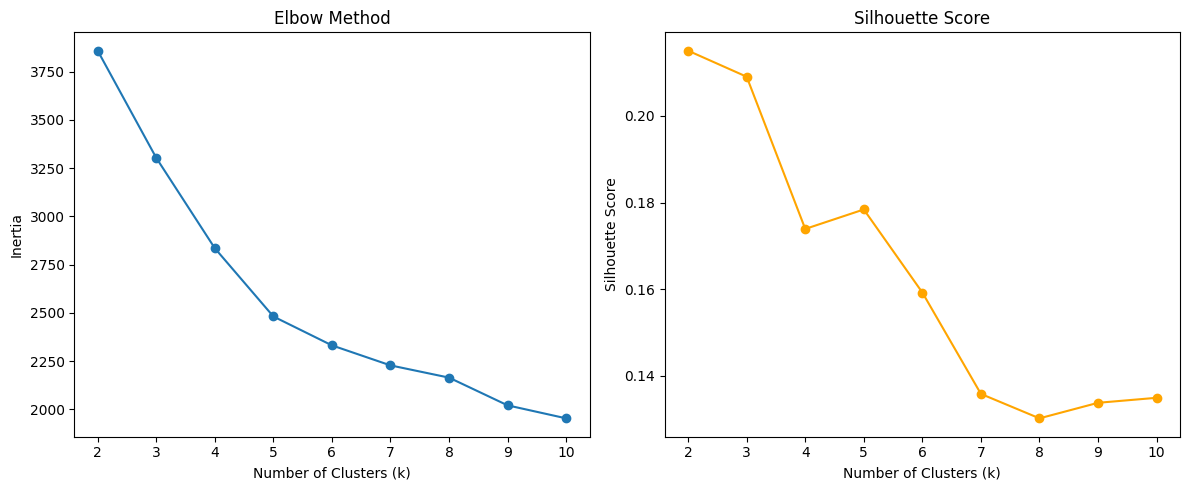

In [25]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia_values, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.tight_layout()
plt.show()

## Model Finaliz

In [29]:
best_k = 3
kmeans_final = KMeans(n_clusters=best_k, random_state=42)
X['cluster'] = kmeans_final.fit_predict(X)
df["cluster"] = X["cluster"]

# Display cluster assignments for the first few records
print("Cluster assignments for the first few records:")
print(X.head())

Cluster assignments for the first few records:
   total_transactions  total_burned  usage_frequency   recency  \
0        8.617808e-01      0.308227        -0.272757 -0.406907   
1       -8.617808e-01     -0.965440        -0.639388  0.918325   
2       -1.065814e-17     -0.965440        -1.152671 -0.650069   
3       -1.723562e+00     -1.602273        -1.922595  2.614378   
4       -4.308904e-01      0.308227         0.964622 -0.631832   

   gender_name_Male  city_name_Aswan  city_name_Asyut  city_name_Beni Suef  \
0              True            False            False                False   
1             False            False            False                False   
2              True             True            False                False   
3             False            False            False                False   
4              True            False            False                False   

   city_name_Cairo  city_name_Damanhur  ...  city_name_Mansoura  \
0            False  

In [30]:
# Analyze clusters
cluster_summary = X.groupby("cluster").mean()
print("\nCluster Summary (Mean Values):")
print(cluster_summary)


Cluster Summary (Mean Values):
         total_transactions  total_burned  usage_frequency   recency  \
cluster                                                                
0                  0.965195      1.046955         0.373043 -0.287931   
1                 -0.370786     -0.362387         0.091191 -0.156926   
2                 -1.057362     -1.290631        -1.255184  1.281214   

         gender_name_Male  city_name_Aswan  city_name_Asyut  \
cluster                                                       
0                0.514286         0.074286         0.040000   
1                0.504912         0.053045         0.043222   
2                0.510638         0.028369         0.042553   

         city_name_Beni Suef  city_name_Cairo  city_name_Damanhur  ...  \
cluster                                                            ...   
0                   0.037143         0.057143            0.042857  ...   
1                   0.031434         0.074656            0.058939  ..

## SEGMENT ANALYSIS

In [31]:
print("=== SEGMENT ANALYSIS ===")

# 1. Cluster Sizes
cluster_sizes = df['cluster'].value_counts().sort_index()
print("\nCluster Sizes (number of customers in each cluster):")
print(cluster_sizes)

# 2. Summary of Numeric Features by Cluster
numeric_features = ["total_transactions", "total_burned", "usage_frequency", "recency"]
cluster_summary = df.groupby('cluster')[numeric_features].mean().round(2)
print("\nMean of Numeric Features per Cluster:")
print(cluster_summary)

# 3. Gender Distribution
if 'gender_name' in df.columns:
    print("\nGender Distribution within Each Cluster (%):")
    gender_dist = (
        df.groupby('cluster')['gender_name']
          .value_counts(normalize=True)
          .mul(100)
          .round(2)
    )
    print(gender_dist)

# 4. City Distribution
if 'city_name' in df.columns:
    print("\nTop 5 Cities per Cluster:")
    for c in sorted(df['cluster'].unique()):
        top_cities = df[df['cluster'] == c]['city_name'].value_counts().head(5)
        print(f"\nCluster {c}:")
        print(top_cities)

# 5. One-Hot Encoding for City or Gender
city_cols = [col for col in df.columns if col.startswith("city_name_")]
if city_cols:
    city_means = df.groupby('cluster')[city_cols].mean().mul(100).round(2)
    print("\nMean City One-Hot Encodings by Cluster (%):")
    print(city_means)

# 6. Detailed Analysis for Each Cluster
for c in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == c]
    print(f"\n--- Detailed Analysis for Cluster {c} ---")
    print(f"Size: {cluster_df.shape[0]} customers")

    # Mean Numeric Features
    print("Mean Numeric Features:")
    print(cluster_df[numeric_features].mean().round(2))

    # Most Common City
    if 'city_name' in df.columns:
        top_city = cluster_df['city_name'].value_counts().idxmax()
        print(f"Most Common City: {top_city}")

    # Gender Breakdown
    if 'gender_name' in df.columns:
        gender_breakdown = (
            cluster_df['gender_name']
            .value_counts(normalize=True)
            .mul(100)
            .round(2)
        )
        print("Gender Breakdown (%):")
        print(gender_breakdown)

print("\n=== END OF SEGMENT ANALYSIS ===")


=== SEGMENT ANALYSIS ===

Cluster Sizes (number of customers in each cluster):
cluster
0    350
1    509
2    141
Name: count, dtype: int64

Mean of Numeric Features per Cluster:
         total_transactions  total_burned  usage_frequency  recency
cluster                                                            
0                      7.24          4.16             0.60    68.57
1                      4.14          1.95             0.52    90.12
2                      2.55          0.49             0.17   326.70

Mean City One-Hot Encodings by Cluster (%):
         city_name_Aswan  city_name_Asyut  city_name_Beni Suef  \
cluster                                                          
0                   7.43             4.00                 3.71   
1                   5.30             4.32                 3.14   
2                   2.84             4.26                 4.96   

         city_name_Cairo  city_name_Damanhur  city_name_Damietta  \
cluster                              

In [34]:
# Group by cluster and compute average metrics
cluster_summary = df.groupby("cluster").agg({
    "usage_frequency": "mean",
    "total_transactions": "mean",
    "total_burned": "mean",
    "recency": "mean"
}).reset_index()

print("=== Cluster Summary ===")
print(cluster_summary)

=== Cluster Summary ===
   cluster  usage_frequency  total_transactions  total_burned     recency
0        0         0.596328            7.240000      4.160000   68.571429
1        1         0.523113            4.139489      1.946955   90.121807
2        2         0.173370            2.546099      0.489362  326.695035


In [35]:
# Define a function to generate coupon strategy recommendations based on average metrics for each cluster.
def generate_recommendation(row):
    # These thresholds are examples
    if row['usage_frequency'] > 0.6 and row['recency'] < 30:
        return ("**High Engagement Segment**: These customers frequently use coupons and are very active. "
                "Consider offering loyalty rewards, exclusive deals, or VIP coupons to maintain their interest.")
    elif row['usage_frequency'] < 0.3 and row['recency'] > 60:
        return ("**Low Engagement Segment**: These customers rarely use coupons and have not been active recently. "
                "It's advisable to send reactivation coupons or introductory offers to encourage them to try again.")
    else:
        return ("**Moderate Engagement Segment**: Customers exhibit average coupon usage and activity. "
                "Targeted personalized discounts can be effective to boost their frequency and overall loyalty.")

# Apply the function to each row of the cluster summary
cluster_summary['recommendation'] = cluster_summary.apply(generate_recommendation, axis=1)

print("\n=== Coupon Strategy Recommendations by Cluster ===")
print(cluster_summary[['cluster', 'recommendation']])



=== Coupon Strategy Recommendations by Cluster ===
   cluster                                     recommendation
0        0  **Moderate Engagement Segment**: Customers exh...
1        1  **Moderate Engagement Segment**: Customers exh...
2        2  **Low Engagement Segment**: These customers ra...


## DBSCAN

In [46]:
# Initialize DBSCAN with specified parameters
dbscan = DBSCAN(eps=0.5, min_samples=5)

# Fit the model and predict cluster labels
dbscan_labels = dbscan.fit_predict(X)

# Calculate the number of clusters, excluding noise (-1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN identified {n_clusters_dbscan} clusters.")

# Evaluate the clustering performance if more than one cluster is found
if n_clusters_dbscan > 1:
    sil_score_dbscan = silhouette_score(X, dbscan_labels)
    print(f"Silhouette Score for DBSCAN: {sil_score_dbscan:.3f}")
else:
    print("DBSCAN did not create meaningful clusters or only identified noise.")


DBSCAN identified 3 clusters.
Silhouette Score for DBSCAN: -0.263


## AgglomerativeClustering

In [50]:
agg_clust = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clust.fit_predict(X)

print("Agglomerative Clustering labels:", np.unique(agg_labels))
sil_score_agg = silhouette_score(X, agg_labels)
print(f"Agglomerative Clustering Silhouette Score: {sil_score_agg:.3f}")

Agglomerative Clustering labels: [0 1 2 3]
Agglomerative Clustering Silhouette Score: 0.184


## Visualizations

In [38]:
cluster_summary = df.groupby('cluster').agg({
    'total_transactions': 'mean',
    'total_burned': 'mean',
    'usage_frequency': 'mean',
    'recency': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'num_customers'})

print("=== Cluster Summary (Mean Values) ===")
print(cluster_summary)

=== Cluster Summary (Mean Values) ===
         total_transactions  total_burned  usage_frequency     recency  \
cluster                                                                  
0                  7.240000      4.160000         0.596328   68.571429   
1                  4.139489      1.946955         0.523113   90.121807   
2                  2.546099      0.489362         0.173370  326.695035   

         num_customers  
cluster                 
0                  350  
1                  509  
2                  141  


## Number of Customers per Cluster

<ipython-input-40-2dd9673be79b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


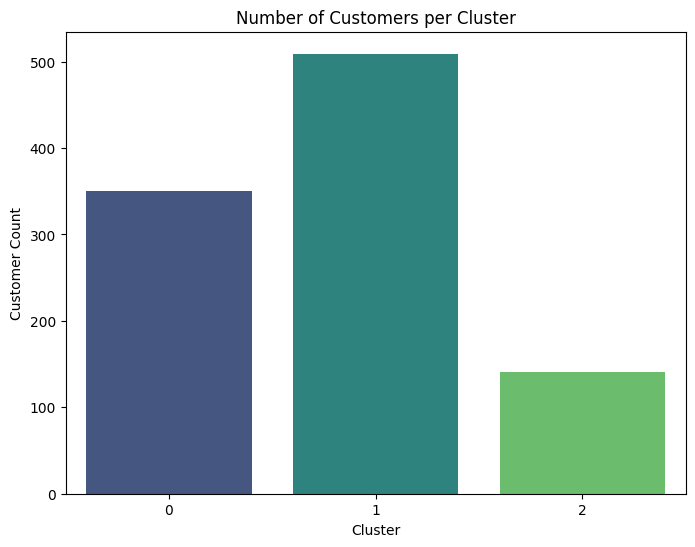

In [40]:
cluster_counts = df['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.title("Number of Customers per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Customer Count")
plt.show()

## Distribution of Usage Frequency per Cluster

<ipython-input-39-9db59f5c037c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='usage_frequency', data=df, palette='viridis')


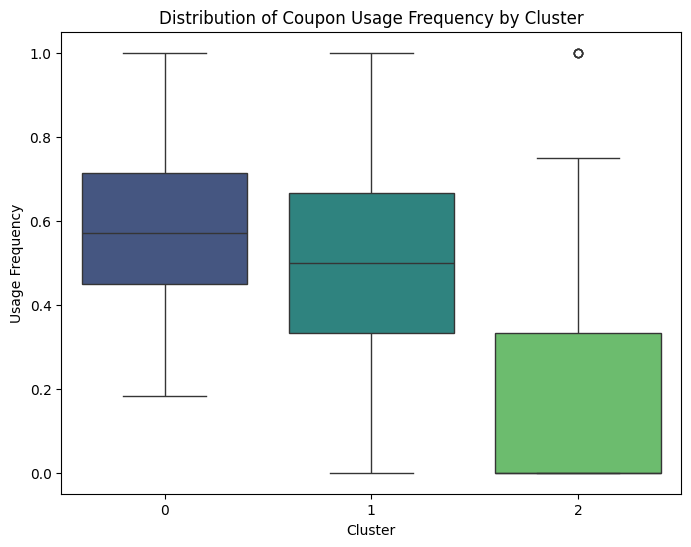

In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='cluster', y='usage_frequency', data=df, palette='viridis')
plt.title("Distribution of Coupon Usage Frequency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Usage Frequency")
plt.show()

In [41]:
def generate_recommendations(cluster_data):
    """Generate tailored recommendations based on customer engagement metrics."""
    recommendations = []

    for _, row in cluster_data.iterrows():
        if row['usage_frequency'] > 0.6 and row['recency'] < 30:
            recommendations.append("High engagement: Offer loyalty rewards and exclusive deals.")
        elif row['usage_frequency'] < 0.3 and row['recency'] > 60:
            recommendations.append("Low engagement: Send reactivation offers or introductory discounts.")
        else:
            recommendations.append("Moderate engagement: Provide targeted personalized discounts.")

    return recommendations

# Apply the recommendation function to the cluster summary DataFrame
cluster_summary['recommendation'] = generate_recommendations(cluster_summary)

# Display the recommendations
print("\n=== Coupon Strategy Recommendations by Cluster ===")
print(cluster_summary[['recommendation']])



=== Coupon Strategy Recommendations by Cluster ===
                                            recommendation
cluster                                                   
0        Moderate engagement: Provide targeted personal...
1        Moderate engagement: Provide targeted personal...
2        Low engagement: Send reactivation offers or in...
